# Visualizing Max and Min Effect Datasets
*April 2020* - J. Nathan Matias

This R script takes data generated by [selecting_upworthy_archive_packages.py.ipynb](selecting_upworthy_archive_packages.py.ipynb) and generates charts that illustrate the range of effect sizes in the datasets.

In [37]:
library(ggplot2)
set.seed(253468449)

In [97]:
max.packages.df <- read.csv("upworthy_archive_exploratory_max_effect_size_dataset.csv")
min.packages.df <- read.csv("upworthy_archive_exploratory_min_effect_size_dataset.csv")
headlines.df <- read.csv("headlines.csv")

## Show Example Rows

Notice that the rows are similar to the data you used in the [headline experiment assignment](https://github.com/natematias/design-governance-experiments/tree/master/assignments/1-headline-experiment). Each row is a viewer:
* **clickability_test_id** (the test number)
* **headline_number**: this is the reference to the specific headline in the headlines CSV
* **has_treatment**: this is 1 if the headline includes a notable person's name name and 0 if it doesn't
* **clicked**: whether that viewer clicked on the package or not 

In [98]:
head(max.packages.df)

clickability_test_id,headline_number,has_treatment,clicked
546f4e0387942a3efd000029,39,1,1
546f4e0387942a3efd000029,39,1,1
546f4e0387942a3efd000029,39,1,1
546f4e0387942a3efd000029,39,1,1
546f4e0387942a3efd000029,39,1,1
546f4e0387942a3efd000029,39,1,1


## Show Results From A Single Test

In [99]:
single.test.df <- subset(max.packages.df, 
                         clickability_test_id==max.packages.df$clickability_test_id[1])


notable.person.headline <- as.character(subset(headlines.df, headline_index==unique(subset(single.test.df, has_treatment==1)$headline_number))$headline)
no.notable.person.headline <- as.character(subset(headlines.df, headline_index==unique(subset(single.test.df, has_treatment==0)$headline_number))$headline)

summary(result.lm <- lm(clicked ~ has_treatment, 
                        data=single.test.df))
# generate a dataframe with a row for whether 
# the headline includes the name of a notable person
estimate.df <- data.frame(has_treatment=c(0,1))

# use the predict() method with the result object
# to create estimates and confidence intervals for each 
preds.df <- data.frame(predict(result.lm, estimate.df, se.fit=TRUE, interval="confidence")$fit)

estimate.df$estimate <- preds.df$fit
estimate.df$estimate.lwr <- preds.df$lwr
estimate.df$estimate.upr <- preds.df$upr

print("Estimates and confidence intervals for each arm.")
estimate.df


Call:
lm(formula = clicked ~ has_treatment, data = single.test.df)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.04291 -0.04291 -0.03229 -0.03229  0.96771 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)   0.032290   0.003456   9.342   <2e-16 ***
has_treatment 0.010622   0.004845   2.192   0.0284 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1904 on 6179 degrees of freedom
Multiple R-squared:  0.0007773,	Adjusted R-squared:  0.0006156 
F-statistic: 4.807 on 1 and 6179 DF,  p-value: 0.02839


[1] "Estimates and confidence intervals for each arm."


has_treatment,estimate,estimate.lwr,estimate.upr
0,0.03228995,0.02551416,0.03906574
1,0.04291163,0.03625645,0.04956682


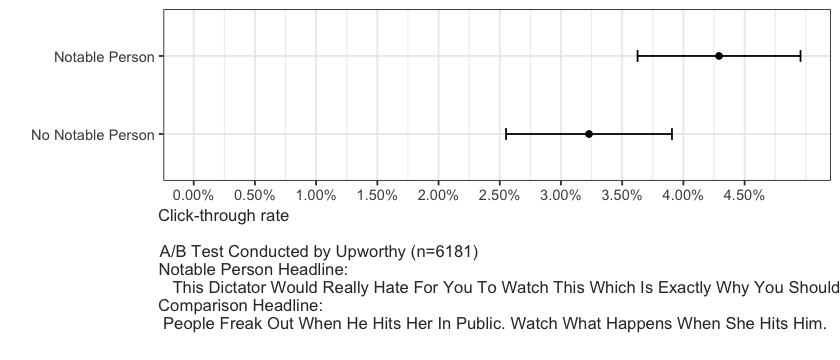

In [100]:
options(repr.plot.width=7, repr.plot.height=3)
ggplot(estimate.df, aes(factor(estimate.df$has_treatment), estimate)) +
    geom_point() +
    geom_errorbar(ymin=estimate.df$estimate.lwr, ymax=estimate.df$estimate.upr, width=0.15) +
    scale_x_discrete(breaks=c(0,1), labels=c("No Notable Person", "Notable Person")) +
    scale_y_continuous(limits=c(0,max(estimate.df$estimate.upr)), 
                       breaks=(seq(0,max(estimate.df$estimate.upr), 0.005)),labels = scales::percent) +
    theme_bw() +
    theme(plot.title = element_text(size=13, face="bold"),
          axis.title.x =element_text(size=10, hjust = -0.01, color = catpalette[1])) +
    coord_flip() + ## This line converts the vertical plot to a horizontal plot
    xlab("") +
    ylab(paste("Click-through rate\n\n", 
               "A/B Test Conducted by Upworthy (n=", 
               nrow(single.test.df), ") \n",
               "Notable Person Headline: ", "\n  ",
               notable.person.headline, "\n",
               "Comparison Headline:", "\n",
               no.notable.person.headline, "\n",
               sep=""))

# Analyze Every Test

This function goes through every unique test and returns a dataframe with the estimate and upper/lower confidence intervals for every test.

In [101]:
analyze.all.tests <- function(df){
    all.tests.df <- data.frame(test.id=character(0), estimate = numeric(0), 
                             estimate.upr = numeric(0), estimate.lwr = numeric(0),
                             p.value = numeric(0))

    for(test.id in unique(df$clickability_test_id)){
        test.viewers <- subset(df, clickability_test_id==test.id)
        summary(result.lm <- lm(clicked ~ has_treatment, data=test.viewers))

        lm.coef <- coef(summary(result.lm))
        estimate.df <- data.frame(
            test.id      = test.id,
            estimate     = lm.coef['has_treatment',][['Estimate']],
            estimate.upr = lm.coef['has_treatment',][['Estimate']] + 1.96 * lm.coef['has_treatment',][['Std. Error']],
            estimate.lwr = lm.coef['has_treatment',][['Estimate']] - 1.96 * lm.coef['has_treatment',][['Std. Error']],
            p.value      = lm.coef['has_treatment',][['Pr(>|t|)']])    
        all.tests.df <- rbind(all.tests.df, estimate.df)
    }
    print(paste(nrow(all.tests.df), "total tests analyzed"))
    all.tests.df
}

In [102]:
max.tests.results.df <- analyze.all.tests(max.packages.df)
min.tests.results.df <- analyze.all.tests(min.packages.df)

[1] "40 total tests analyzed"
[1] "40 total tests analyzed"


## Illustrate Tests
The following function produces a "caterpiller plot" of multiple experiment results, sorted from high to low.

In [122]:
illustrate.result <- function(result.df, viewer.df,
                              plot.title,
                              characteristic_label,
                              no_characteristic_label){

    ggplot(result.df, aes(reorder(test.id, -estimate), estimate)) +
        geom_hline(yintercept=0, color="#ff9900") +
        geom_errorbar(ymin=result.df$estimate.lwr, 
                      ymax=result.df$estimate.upr, 
                      width=0.15, 
                      color="#666666") +
        geom_point(color="#333333", size=0.5) +
        theme_bw() + 
        theme(axis.text.x  = element_blank(),
              axis.ticks.x = element_blank(),
              axis.title.x = element_text(hjust=0, size=10),
              panel.grid.major = element_blank(), 
              panel.grid.minor = element_blank()) +
        scale_y_continuous(breaks=seq(-0.06, 0.06, 0.01), 
                           limits=c(-0.055, 0.055)) +
        xlab(paste("Headline A/B tests conducted by Upworthy that included",
                   characteristic_label,
                   " versus", "\n", "a headline with ", 
                   no_characteristic_label, 
                   " (n=", nrow(result.df), " tests and ",
                   prettyNum(nrow(min.packages.df), big.mark=","), 
                   " viewers)", sep="")) +
        ggtitle(plot.title)
}

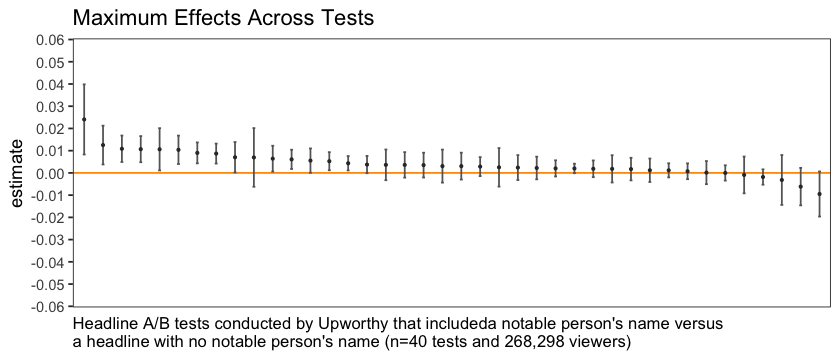

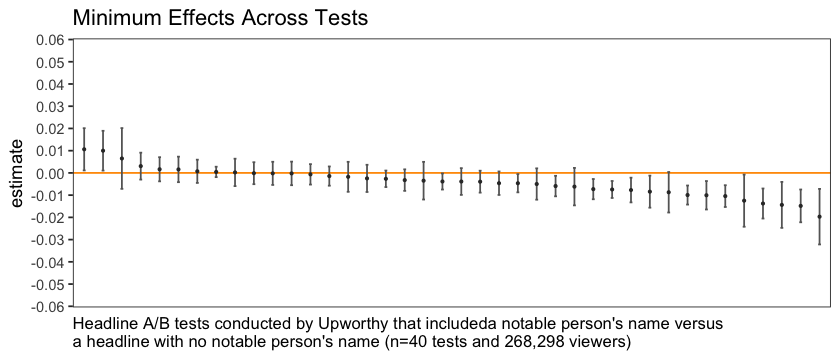

In [123]:
illustrate.result(max.tests.results.df, 
                  max.packages.df,
                  "Maximum Effects Across Tests", 
                  "a notable person's name",
                  "no notable person's name")

illustrate.result(min.tests.results.df, 
                  min.packages.df,
                  "Minimum Effects Across Tests",
                  "a notable person's name",
                  "no notable person's name")

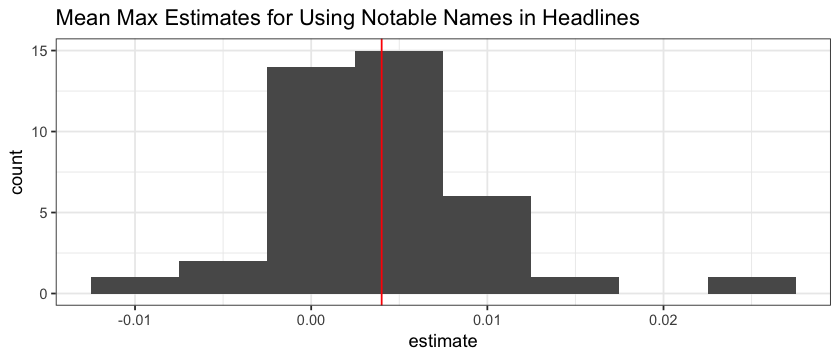

In [115]:
ggplot(max.tests.results.df, aes(estimate)) +
    geom_histogram(binwidth=0.005) +
    theme_bw() + 
    geom_vline(xintercept=mean(max.tests.results.df$estimate), color="red") +
    ggtitle("Mean Max Estimates for Using Notable Names in Headlines")

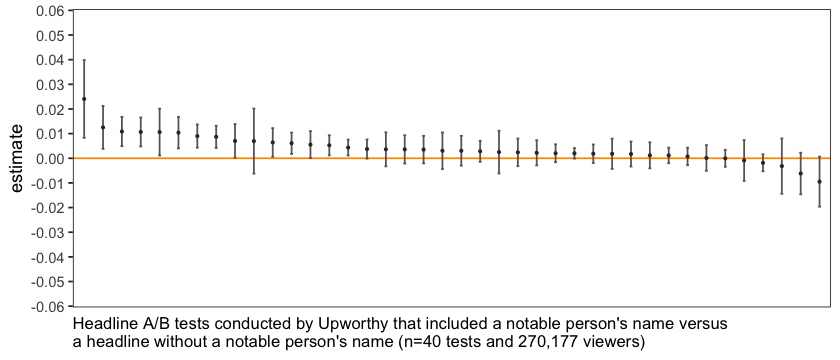

In [109]:
ggplot(max.tests.results.df, aes(reorder(test.id, -estimate), estimate)) +
    geom_hline(yintercept=0, color="#ff9900") +
    geom_errorbar(ymin=max.tests.results.df$estimate.lwr, ymax=max.tests.results.df$estimate.upr, width=0.15, color="#666666") +
    geom_point(color="#333333", size=0.5) +
    theme_bw() + 
    theme(axis.text.x  = element_blank(),
          axis.ticks.x = element_blank(),
          axis.title.x = element_text(hjust=0, size=10),
          panel.grid.major = element_blank(), 
          panel.grid.minor = element_blank()) +
    scale_y_continuous(breaks=seq(-0.06, 0.06, 0.01), limits=c(-0.055, 0.055)) +
    xlab(paste("Headline A/B tests conducted by Upworthy that included a notable person's name versus", "\n",
               "a headline without a notable person's name (n=", nrow(max.tests.results.df), " tests and ",
               prettyNum(nrow(max.packages.df), big.mark=","), " viewers)", sep=""))

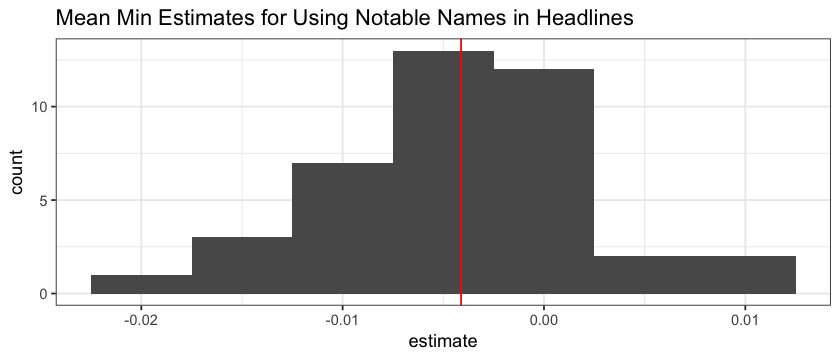

In [105]:
ggplot(min.tests.results.df, aes(estimate)) +
    geom_histogram(binwidth=0.005) +
    theme_bw() + 
    geom_vline(xintercept=mean(min.tests.results.df$estimate), color="red") +
    ggtitle("Mean Min Estimates for Using Notable Names in Headlines")